---

**Load essential libraries**

---

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
%matplotlib inline
import tensorflow as tf
import sys
import h5py # this library is used to save weights of the model
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix

---

Load MNIST data

---

In [77]:
## Load MNIST data (note that shape of X_train and y_train)
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
print(X_train.shape)
print(y_train.shape)

(60000, 28, 28)
(60000,)


In [78]:
## Reshape X_train and X_test such that the samples are along the rows
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])  # Reshape to (num_samples, 784)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])
print(X_train_reshaped.shape)
print(X_test_reshaped.shape)

(60000, 784)
(10000, 784)


In [79]:
## Min-max scale the images using scikit-learn
mms = MinMaxScaler()
X_train_reshaped_scaled = mms.fit_transform(X_train_reshaped)
X_test_reshaped_scaled = mms.transform(X_test_reshaped)

In [80]:
## Problem parameters
num_samples_train = X_train_reshaped_scaled.shape[0]
num_samples_test = X_test_reshaped_scaled.shape[0]
num_features = X_train_reshaped_scaled.shape[1]
num_labels = 10
print(f'No. of training samples = {num_samples_train},\
 No. of test samples = {num_samples_test}, \
 no. of features = {num_features}, no. of labels = {num_labels}')

No. of training samples = 60000, No. of test samples = 10000,  no. of features = 784, no. of labels = 10


In [81]:
## One-hot encode output labels using scikit-learn (observe the shape of Y_train)
ohc = OneHotEncoder()
Y_train = ohc.fit_transform(y_train.reshape(-1, 1))
Y_test = ohc.transform(y_test.reshape(-1, 1))
Y_train.shape

(60000, 10)

---

Define the linear layer

---

In [82]:
class LinearLayer(tf.keras.layers.Layer):
  def __init__(self, nodes=2):
    super().__init__() # use parent class 'Layer' constructor
    self.nodes = nodes

  def build(self, input_shape): # initialize the variables accosiated with LinearLayer
    self.W = self.add_weight(shape = (input_shape[-1], self.nodes), # feautres x neurons
                             dtype = tf.float32,
                             initializer = tf.initializers.RandomNormal() # initialize weights values randomly but close to 0
                             )
    self.b = self.add_weight(shape = (self.nodes, ),
                             dtype = tf.float32,
                             initializer = tf.initializers.RandomUniform() # initialize bias values randomly in range(-1,1)
                             )
  def call(self, input): # perform compuation based on input
    input = tf.cast(input, dtype=tf.float32)
    output = tf.linalg.matmul(input, self.W) + self.b
    return output

In [83]:
ll = LinearLayer(nodes=num_labels)
Z = ll(X_train_reshaped_scaled)

In [84]:
Z

<tf.Tensor: shape=(60000, 10), dtype=float32, numpy=
array([[-0.39046022, -0.14868215,  0.5208598 , ...,  0.35303608,
         0.35605833,  0.29801464],
       [-0.45713276, -0.10147268,  0.1565415 , ...,  0.0139293 ,
         1.012447  ,  0.5571058 ],
       [ 0.24170652,  0.27016598, -0.25384447, ...,  0.07900737,
         0.28944093, -0.31392932],
       ...,
       [-0.4450251 , -0.48989248,  0.12073756, ...,  0.21708348,
         0.12653969,  0.2863836 ],
       [-0.48921925,  0.11717599,  0.43056288, ...,  0.01365707,
         0.16201678, -0.04729123],
       [ 0.25010952, -0.18425307,  0.25421447, ..., -0.24857438,
         0.45948187, -0.16830093]], dtype=float32)>

---

Define the softmax layer

---

In [85]:
class SoftmaxLayer(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__()
    self.activation = tf.keras.layers.Softmax()

  def call(self, input):
    input = tf.cast(input, dtype=tf.float32)
    output = self.activation(input)
    return output

In [86]:
softmax = SoftmaxLayer()
A = softmax(Z)

In [87]:
A

<tf.Tensor: shape=(60000, 10), dtype=float32, numpy=
array([[0.06203166, 0.07899803, 0.1543102 , ..., 0.13046972, 0.13086462,
        0.12348501],
       [0.05677274, 0.08102164, 0.10487095, ..., 0.09093258, 0.24681425,
        0.15653737],
       [0.12935847, 0.13309282, 0.07880972, ..., 0.10993487, 0.13568306,
        0.0742139 ],
       ...,
       [0.06208424, 0.05936025, 0.10931733, ..., 0.12037367, 0.10995344,
        0.12901142],
       [0.06405674, 0.11746784, 0.16070196, ..., 0.10591592, 0.12285507,
        0.09965332],
       [0.12843479, 0.08318431, 0.12896308, ..., 0.07800224, 0.15834777,
        0.08452192]], dtype=float32)>

---

Define the softmax classifier model

---

In [88]:
class SoftmaxClassifierModel(tf.keras.Model):
  def __init__(self, nodes=2):
    super().__init__()
    self.nodes = nodes
    self.ll = LinearLayer(self.nodes)
    self.softmax = SoftmaxLayer()

  def call(self, input):
    input = tf.cast(input, dtype=tf.float32)
    Z = self.ll(input)
    A = self.softmax(Z)
    return A

In [89]:
model = SoftmaxClassifierModel(nodes=num_labels)
Y_hat = model(X_train_reshaped_scaled)

In [90]:
Y_hat.shape

TensorShape([60000, 10])

---

Define loss function

---

In [91]:
def loss_fn(actual, predicted):
  loss = tf.keras.losses.categorical_crossentropy(actual.todense(), predicted) # method
  '''
  cce = tf.keras.losses.CategoricalCrossentropy() # it is a class
  loss = cce(actual.todense(), predicted)
  '''
  return tf.reduce_mean(loss)

In [92]:
loss_fn(Y_train ,Y_hat)

<tf.Tensor: shape=(), dtype=float32, numpy=2.4337692>

---

Train model

---

In [95]:
## Train model
nodes = 10
model = SoftmaxClassifierModel(nodes)

# Gradient descent
maxiter = 1000
tol = 1e-04
lr = 1e-03
norm_grad = np.inf
optimizer = tf.optimizers.RMSprop(learning_rate=lr)
# Empty list to store training loss every step
loss_train = []
k = 0
while k < maxiter and norm_grad > tol:
  with tf.GradientTape() as tape:
    Yhat = model(X_train_reshaped_scaled)
    L = loss_fn(Y_train, Yhat)

  # Append training loss values
  loss_train.append(L)
  k = k+1
  print(f'Iteration {k}, Training loss = {L}')
  gradients = tape.gradient(L, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables)) # w = w + lr*gradient

Iteration 1, Training loss = 2.371873378753662
Iteration 2, Training loss = 2.211620569229126
Iteration 3, Training loss = 2.106198310852051
Iteration 4, Training loss = 2.0224967002868652
Iteration 5, Training loss = 1.9515858888626099
Iteration 6, Training loss = 1.8893156051635742
Iteration 7, Training loss = 1.833390474319458
Iteration 8, Training loss = 1.7823835611343384
Iteration 9, Training loss = 1.7353392839431763
Iteration 10, Training loss = 1.69158136844635
Iteration 11, Training loss = 1.6506110429763794
Iteration 12, Training loss = 1.6120476722717285
Iteration 13, Training loss = 1.5755934715270996
Iteration 14, Training loss = 1.541009545326233
Iteration 15, Training loss = 1.5081007480621338
Iteration 16, Training loss = 1.4767062664031982
Iteration 17, Training loss = 1.4466900825500488
Iteration 18, Training loss = 1.4179368019104004
Iteration 19, Training loss = 1.3903471231460571
Iteration 20, Training loss = 1.3638352155685425
Iteration 21, Training loss = 1.3383

---

Plot training loss

---

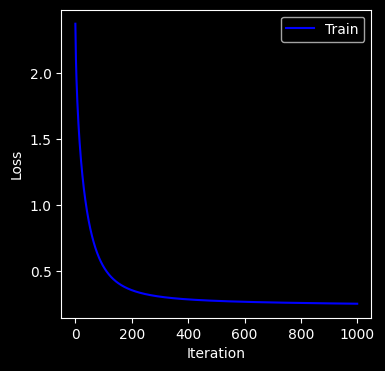

In [96]:
## Plot the training loss
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.plot(loss_train, 'b', label = 'Train')
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.legend()

In [97]:
## Assess model performance on test data
Yhat = model.predict(X_test_reshaped_scaled)

ypred = np.argmax(Yhat, axis = 1) #predicted labels
ytrue = np.asarray(np.argmax(Y_test, axis=1)).flatten() #true labels
print('Accuracy on test data = %3.2f'%(np.mean(ytrue == ypred)*100))
# Print confusion matrix
print(confusion_matrix(ytrue, ypred))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy on test data = 92.67
[[ 962    0    1    2    0    5    6    3    1    0]
 [   0 1111    3    2    0    1    4    2   12    0]
 [   6    9  924   16   10    3   13    9   37    5]
 [   3    0   19  923    0   22    2   11   23    7]
 [   1    2    5    2  918    0   10    3    9   32]
 [   9    2    3   35   10  771   15    9   32    6]
 [   9    3    7    1    9   13  912    2    2    0]
 [   1    6   23    5    7    1    0  953    3   29]
 [   6    9    5   20    9   22    9   12  877    5]
 [  11    8    1    9   26    7    0   25    6  916]]


Image classified as 2


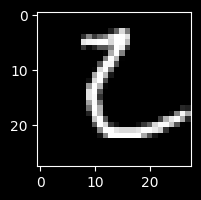

In [103]:
## Plot a random test sample with its predicted label printed above the plot
test_index = np.random.choice(X_test.shape[0])
fig, ax = plt.subplots(1, 1, figsize = (2, 2))
print(f'Image classified as {ypred[test_index]}')
ax.imshow(tf.reshape(X_test_reshaped_scaled[test_index], [28, 28]).numpy(), cmap = 'gray');